In [1]:
# Change working directory
%cd ..

d:\Workplaces\Thesis\ot-kpgf


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import json
import pandas as pd
import numpy as np
import scipy
import os
import ot
from optimal_transport.models import KeypointFOT, FOT, LOT, EMD
from optimal_transport.experiments import OutlierRate, ClusterMismatch, Dimensionality
from typing import Tuple, Optional, List, Union, Dict

# To make this notebook's output stable across runs
seeds = [i for i in range(1, 11)]

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

Dimension: 10, Accuracy: {'KeypointFOT': 0.9, 'FOT': 0.9333333333333333, 'LOT': 0.75, 'OT': 0.6666666666666666}, Deviation: {'KeypointFOT': 0, 'FOT': 0, 'LOT': 0, 'OT': 0}, Runtime: {'KeypointFOT': 0.6799664497375488, 'FOT': 2.630361557006836, 'LOT': 0.800163984298706, 'OT': 0.0010039806365966797}
Dimension: 20, Accuracy: {'KeypointFOT': 1.0, 'FOT': 1.0, 'LOT': 0.6, 'OT': 0.75}, Deviation: {'KeypointFOT': 0.36835757879433983, 'FOT': 0.3361852256648219, 'LOT': 2.2789229951982086e-13, 'OT': 1.3904435743076142}, Runtime: {'KeypointFOT': 0.8479692935943604, 'FOT': 3.93180513381958, 'LOT': 0.7389416694641113, 'OT': 0.001997232437133789}
Dimension: 30, Accuracy: {'KeypointFOT': 1.0, 'FOT': 1.0, 'LOT': 0.5333333333333333, 'OT': 0.6666666666666666}, Deviation: {'KeypointFOT': 0.35043832708886885, 'FOT': 0.33646967703124997, 'LOT': 3.831306992856981e-12, 'OT': 1.3904435743076142}, Runtime: {'KeypointFOT': 0.4924652576446533, 'FOT': 1.0501813888549805, 'LOT': 1.2444515228271484, 'OT': 0.00100207

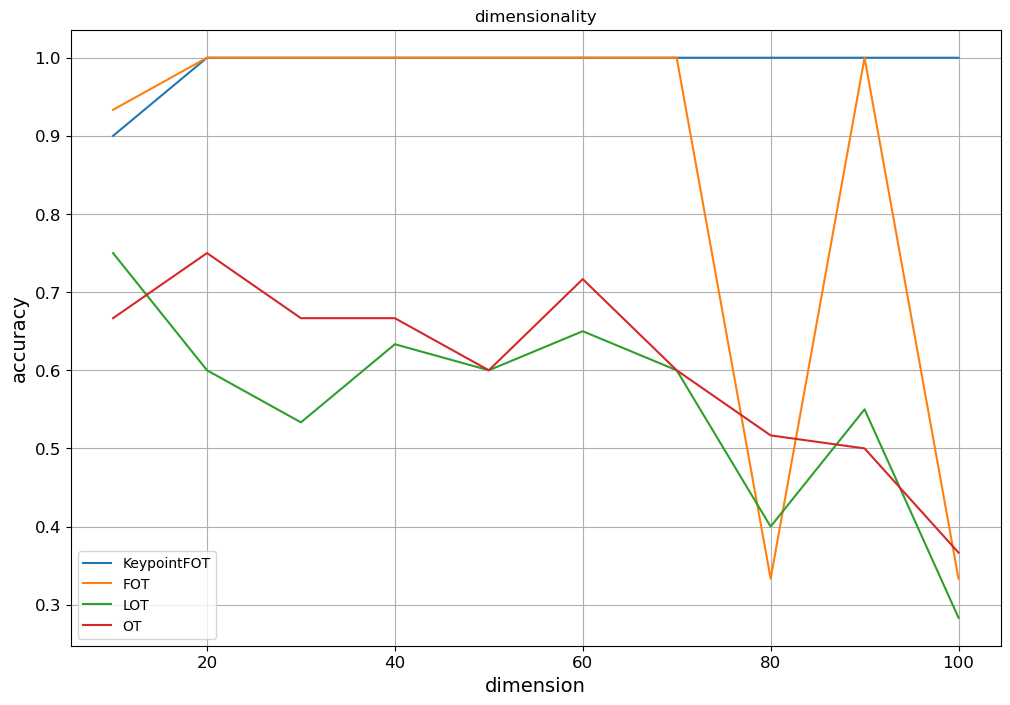

In [28]:
#@title Dimensionality
for seed in seeds:
    np.random.seed(seed)
    n_anchors = 3
    n_keypoints = 3
    k = 3
    models = {
        "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, guide_mixing=0.5, stop_thr=1e-5,
                                sinkhorn_reg=0.0005, temperature=0.01, div_term=1e-10, max_iters=200),
        "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
        "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
        "OT": EMD(),
    }

    experiment = Dimensionality(model=models, log_dir="logs")
    results = experiment(
        max_projected_dim=100, freq_projected_dim=10, hyperplane_dim=10,
        n_components=k, cluster_samples=20, n_keypoints=n_keypoints, is_checkpoint=False,
        src_properties={"cluster_distance": 1, "cluster_sparity": 0.1},
        target_properties={"cluster_distance": 2, "cluster_sparity": 0.2}
)

Noise ratio: 0.0, Accuracy: {'KeypointFOT': 1.0, 'FOT': 1.0, 'LOT': 0.6333333333333333, 'OT': 0.73}, Deviation: {'KeypointFOT': 0, 'FOT': 0, 'LOT': 0, 'OT': 0}, Runtime: {'KeypointFOT': 0.99631667137146, 'FOT': 1.6532485485076904, 'LOT': 1.108952283859253, 'OT': 0.04564952850341797}
Noise ratio: 0.1, Accuracy: {'KeypointFOT': 1.0, 'FOT': 1.0, 'LOT': 0.7533333333333333, 'OT': 0.7133333333333334}, Deviation: {'KeypointFOT': 0.10050378153129384, 'FOT': 0.026376480057368774, 'LOT': 3.346524305594082e-12, 'OT': 1.407124727947029}, Runtime: {'KeypointFOT': 0.9321348667144775, 'FOT': 2.7245237827301025, 'LOT': 1.170166015625, 'OT': 0.04011416435241699}
Noise ratio: 0.2, Accuracy: {'KeypointFOT': 0.9966666666666667, 'FOT': 0.9933333333333333, 'LOT': 0.37333333333333335, 'OT': 0.5066666666666667}, Deviation: {'KeypointFOT': 0.12916330018663252, 'FOT': 0.20050656866264568, 'LOT': 3.79910585223626e-12, 'OT': 1.4094916341243984}, Runtime: {'KeypointFOT': 1.1511764526367188, 'FOT': 3.16538143157959

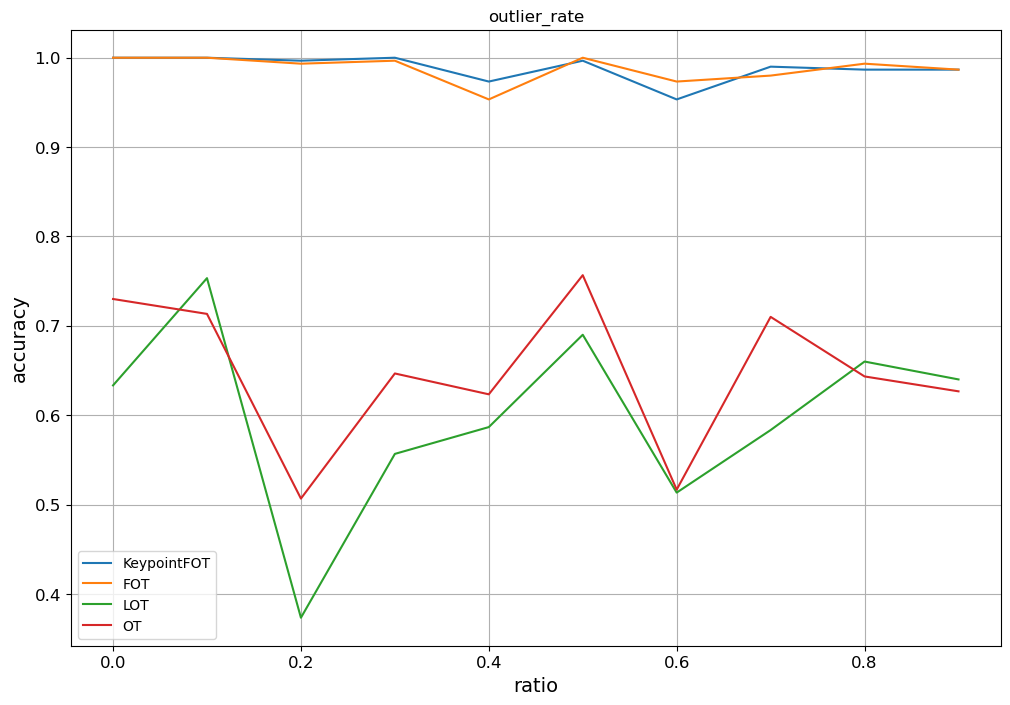

In [29]:
#@title Outlier rate
n_anchors = 3
n_keypoints = 3
d = 30
k = 3
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, guide_mixing=0.5, stop_thr=1e-5,
                               sinkhorn_reg=0.0005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

experiment = OutlierRate(model=models, log_dir="logs")
results = experiment(
    max_noise_ratio=1, freq_noise_ratio=0.1, hyperplane_dim=d, intensity = 0.1,
    cluster_samples=100, n_keypoints=n_keypoints, n_components=k, is_checkpoint=False,
    src_properties={"cluster_distance": 1, "cluster_sparity": 0.1},
    target_properties={"cluster_distance": 2, "cluster_sparity": 0.2}
)

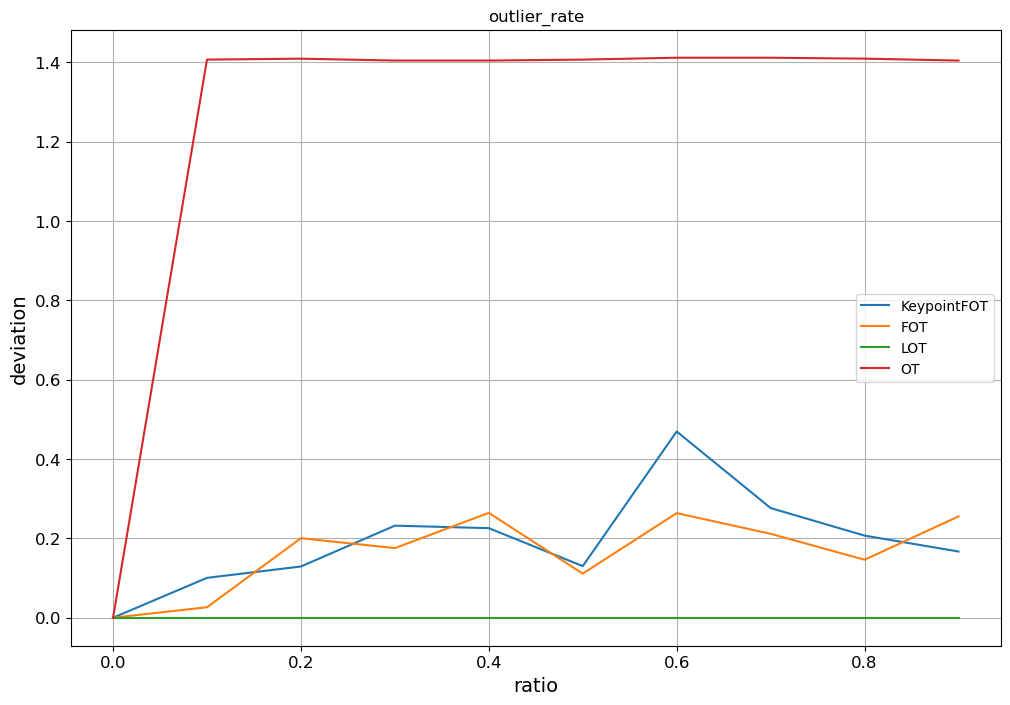

In [30]:
experiment.plot(x_axis="ratio", y_axis="deviation")

Number of source components: 2, Accuracy: {'KeypointFOT': 0.19, 'FOT': 0.1, 'LOT': 0.0, 'OT': 0.12}, Runtime: {'KeypointFOT': 4.780042886734009, 'FOT': 5.9960267543792725, 'LOT': 1.38515043258667, 'OT': 0.0802152156829834}
Number of source components: 3, Accuracy: {'KeypointFOT': 0.45, 'FOT': 0.11, 'LOT': 0.0, 'OT': 0.13}, Runtime: {'KeypointFOT': 4.877001523971558, 'FOT': 9.572352170944214, 'LOT': 1.323969841003418, 'OT': 0.11686110496520996}
Number of source components: 4, Accuracy: {'KeypointFOT': 0.2725, 'FOT': 0.125, 'LOT': 0.0, 'OT': 0.1375}, Runtime: {'KeypointFOT': 4.167091131210327, 'FOT': 5.884702444076538, 'LOT': 1.4153895378112793, 'OT': 0.13940930366516113}
Number of source components: 5, Accuracy: {'KeypointFOT': 0.37, 'FOT': 0.164, 'LOT': 0.0, 'OT': 0.122}, Runtime: {'KeypointFOT': 4.859597682952881, 'FOT': 7.141042947769165, 'LOT': 1.8668055534362793, 'OT': 0.17950773239135742}
Number of source components: 6, Accuracy: {'KeypointFOT': 0.4533333333333333, 'FOT': 0.198333

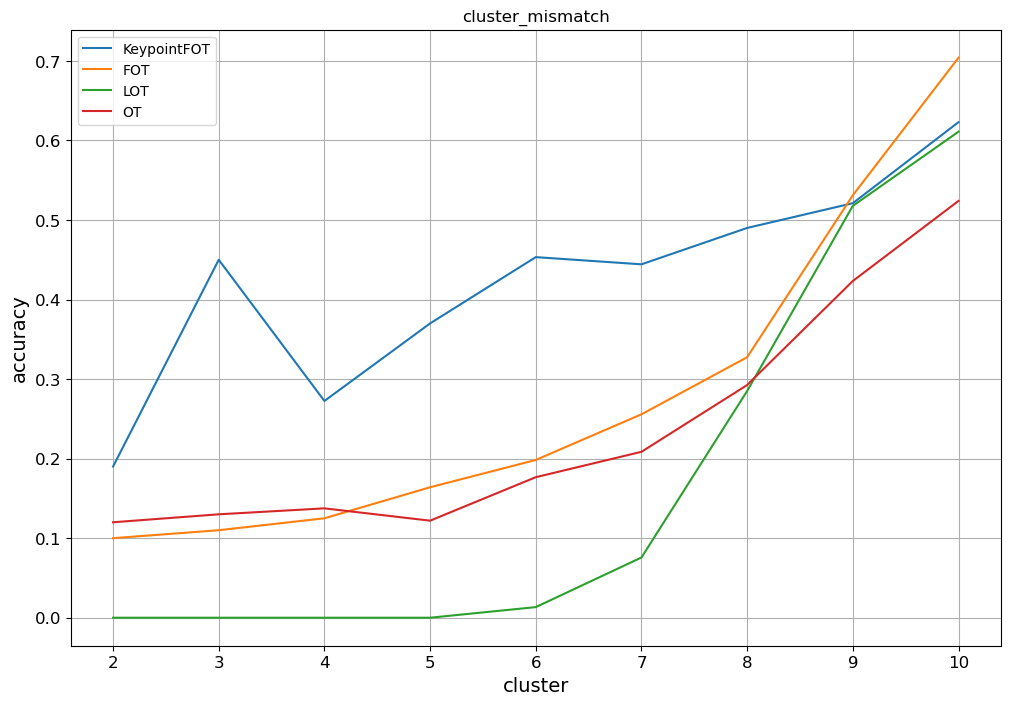

In [3]:
#@title ClusterMismatch
n_anchors = 4
n_keypoints = 10
d = 30
k = 10
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, guide_mixing=0.5, stop_thr=1e-5,
                               sinkhorn_reg=0.0005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

experiment = ClusterMismatch(model=models, log_dir="logs")
results = experiment(
    min_source_components=2, freq_components=1, target_components=k, 
    hyperplane_dim=d, cluster_samples=100, n_keypoints=n_keypoints, is_checkpoint=False,
    src_properties={"cluster_distance": 1, "cluster_sparity": 0.1},
    target_properties={"cluster_distance": 1, "cluster_sparity": 0.1}
)